In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import math
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from dateutil.parser import parse
import statsmodels.formula.api as smf

In [2]:
## Get current working directory
print(os.getcwd())

/Users/rajanand/Dropbox (MIT)/MIT Acad/458 Financial Data Science and Computing


In [3]:
## Importing equity data
data = pd.read_csv('ProjectC_FF_v2.txt')
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
### Removing the ticker and d column
data.drop(columns=['d','ticker'], inplace=True)
data.set_index('Date', inplace=True)
print(data.head())
print(data.tail())

                Beta    Return       SPX      SPTR       VIX   mktrf     smb  \
Date                                                                           
2001-01-02  0.733649 -0.030214 -0.028432 -0.028432  0.110598 -0.0345 -0.0039   
2001-01-03  0.792108  0.053745  0.048884  0.049009 -0.119953  0.0527  0.0097   
2001-01-04  0.793228 -0.005831 -0.010608 -0.010584  0.013814 -0.0121  0.0082   
2001-01-05  0.820053 -0.041797 -0.026593 -0.026587  0.061126 -0.0291  0.0027   
2001-01-08  0.820903 -0.003054 -0.001920 -0.001711  0.039998 -0.0037 -0.0054   

               hml       rf     umd  
Date                                 
2001-01-02  0.0209  0.00026 -0.0123  
2001-01-03 -0.0491  0.00026 -0.0727  
2001-01-04 -0.0014  0.00026 -0.0415  
2001-01-05  0.0242  0.00026  0.0066  
2001-01-08  0.0128  0.00026  0.0017  
                Beta    Return       SPX      SPTR       VIX   mktrf     smb  \
Date                                                                           
2009-12-24  0

In [4]:
### Converting the log return to simple return
data[['Return','SPX','SPTR','VIX','mktrf','rf']] = data[['Return','SPX','SPTR','VIX','mktrf','rf']].applymap(lambda x: math.exp(float(x)) -1)

In [5]:
data.describe()

,Beta,Return,SPX,SPTR,VIX,mktrf,smb,hml,rf,umd
count,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000
mean,0.776022,0.000036,0.000023,0.000098,0.001737,0.000161,0.000208,0.000228,0.000095,-0.000014
std,0.106578,0.012745,0.014005,0.014005,0.061651,0.013901,0.005962,0.006570,0.000067,0.011829
min,0.410095,-0.094771,-0.090350,-0.090259,-0.259087,-0.086069,-0.038000,-0.049100,0.000000,-0.082500
25%,0.701459,-0.005379,-0.006193,-0.006089,-0.035293,-0.006032,-0.003150,-0.002400,0.000040,-0.004600
50%,0.774295,0.000000,0.000588,0.000657,-0.004812,0.000600,0.000400,0.000200,0.000070,0.000600
75%,0.848466,0.005790,0.006157,0.006227,0.032124,0.006219,0.003700,0.002800,0.000150,0.005000
max,1.082567,0.105634,0.115800,0.115808,0.642152,0.121986,0.043100,0.040100,0.000260,0.071000


### Question 1

In [6]:
### Subsetting the data for Question 1
benchmark = data['1/1/2008':'1/1/2010']
benchmark.tail()

,Beta,Return,SPX,SPTR,VIX,mktrf,smb,hml,rf,umd
Date,,,,,,,,,,
2009-12-24,0.955339,0.004200,0.005256,0.005254,-0.012177,0.005214,-0.0008,0.0016,0.0,0.0025
2009-12-28,0.955054,0.000738,0.001154,0.001286,0.023626,0.001001,-0.0015,-0.0030,0.0,-0.0018
2009-12-29,0.954065,-0.000983,-0.001401,-0.001227,0.004014,-0.000900,0.0008,-0.0008,0.0,-0.0037
2009-12-30,0.954356,-0.001968,0.000195,0.000287,-0.002499,-0.000700,-0.0004,-0.0018,0.0,-0.0010
2009-12-31,0.950090,-0.003945,-0.010050,-0.010043,0.086172,-0.008761,-0.0013,0.0015,0.0,0.0005


In [7]:
### Dividing the benchmark data for SPX, SPTR and VIX
spx = benchmark[['Return','SPX']]
spx = spx.sub(benchmark['rf'], axis=0).dropna(axis=0, how='all')
print(spx.shape)
spx.head()

(505, 2)


,Return,SPX
Date,,
2008-01-02,-0.027012,-0.014538
2008-01-03,-0.005922,-0.000100
2008-01-04,-0.030115,-0.024652
2008-01-07,-0.002945,0.003123
2008-01-08,-0.017682,-0.018452


In [8]:
### Dividing the benchmark data for SPX, SPTR and VIX
sptr = benchmark[['Return','SPTR']]
sptr = sptr.sub(benchmark['rf'], axis=0).dropna(axis=0, how='all')
print(sptr.shape)
sptr.head()

(505, 2)


,Return,SPTR
Date,,
2008-01-02,-0.027012,-0.014334
2008-01-03,-0.005922,-0.000096
2008-01-04,-0.030115,-0.024654
2008-01-07,-0.002945,0.003133
2008-01-08,-0.017682,-0.018122


In [9]:
### Dividing the benchmark data for SPX, SPTR and VIX
vix = benchmark[['Return','VIX']]
vix = vix.sub(benchmark['rf'], axis=0).dropna(axis=0, how='all')
print(vix.shape)
vix.head()

(505, 2)


,Return,VIX
Date,,
2008-01-02,-0.027012,0.029678
2008-01-03,-0.005922,-0.029448
2008-01-04,-0.030115,0.064373
2008-01-07,-0.002945,-0.006366
2008-01-08,-0.017682,0.068837


In [10]:
### Rolling 3Month beta with SPX Calculated value
spx_reg = RollingOLS(spx['Return'], sm.add_constant(spx['SPX']), window=66).fit()
spx_params = spx_reg.params
spx_params

,const,SPX
Date,,
2008-01-02,NaN,NaN
2008-01-03,NaN,NaN
2008-01-04,NaN,NaN
2008-01-07,NaN,NaN
2008-01-08,NaN,NaN
...,...,...
2009-12-24,0.000064,0.975988
2009-12-28,0.000028,0.978623
2009-12-29,0.000168,0.966431


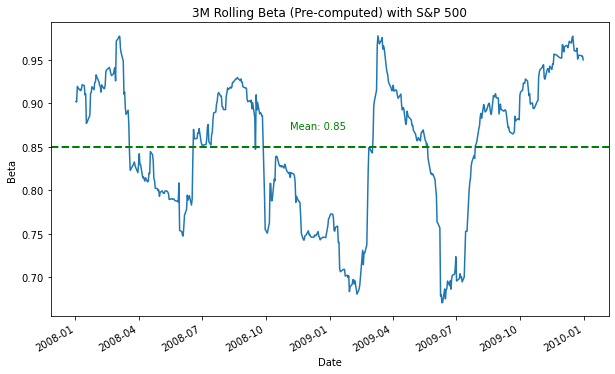

In [11]:
### Plotting the rolling beta (pre-Calculated)
benchmark['Beta'].plot(figsize=(10,6))
plt.title('3M Rolling Beta (Pre-computed) with S&P 500')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.axhline(benchmark['Beta'].mean(), color='green',linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(733350 , 0.87, 'Mean: {:.2f}'.format(benchmark['Beta'].mean()), fontsize=10, color='g')
plt.savefig('RollingBeta.jpeg')
plt.show()

In [12]:
min_xlim

733006.55

In [13]:
max_xlim

733808.45

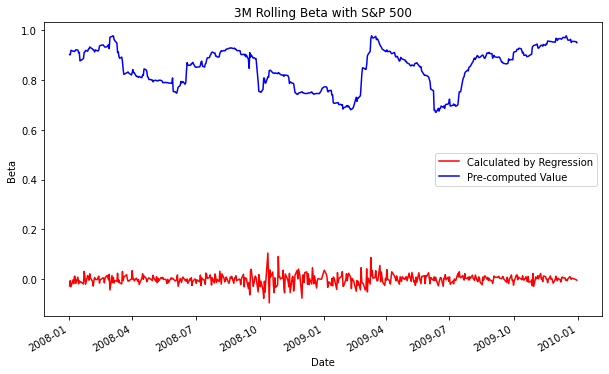

In [14]:
### Plotting the precomputed Beta
### Plotting the rolling beta (Calculated)
benchmark['Return'].plot(figsize=(10,6), color='red', label='Calculated by Regression')
benchmark['Beta'].plot(color='blue', label='Pre-computed Value')
plt.title('3M Rolling Beta with S&P 500')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
#plt.savefig('RollingBeta_comp.jpeg')
plt.show()

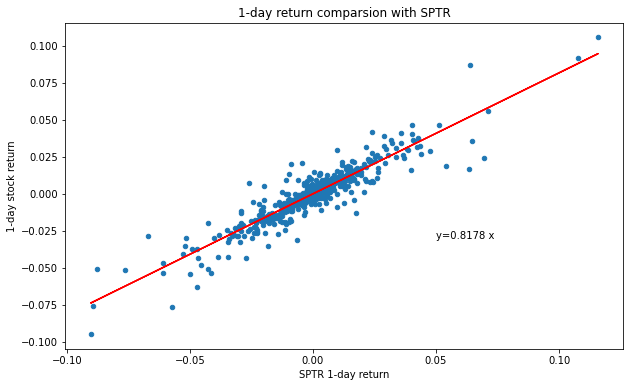

In [15]:
### Scatter plot for 1-day stock return with SPTR
fit_sptr = np.polyfit(sptr['SPTR'], sptr['Return'], deg=1)

sptr.plot(kind='scatter', x ='SPTR', y='Return', figsize=(10,6))
plt.xlabel('SPTR 1-day return')
plt.ylabel('1-day stock return')

plt.plot(sptr['SPTR'], fit_sptr[0]*sptr['SPTR'] + fit_sptr[1], color='red')
plt.annotate('y={0:.4f} x '.format(fit_sptr[0]), xy=(0.05, -0.03))
plt.title('1-day return comparsion with SPTR')
plt.savefig('SPTRComp.jpeg')
plt.show()

In [16]:
### Finding the statistics for regression. 
sptr_reg = smf.ols('Return ~ SPTR', data=sptr).fit()
sptr_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     2791.
Date:                Fri, 16 Oct 2020   Prob (F-statistic):          2.04e-207
Time:                        18:57:11   Log-Likelihood:                 1746.8
No. Observations:                 505   AIC:                            -3490.
Df Residuals:                     503   BIC:                            -3481.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.382e-05      0.000     -0.188      0.851      -0.001       0.001
SPTR           0.8178      0.015     52.834      0.000       0.787       0.848
==============================================================================
Omnibus:                       62.071   Durbin-Watson:                   2.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              417.282
Skew:                          -0.234   Prob(JB):                     2.45e-91
Kurtosis:                       7.429   Cond. No.                         45.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
benchmark['Beta'].mean()

0.8501647928576982

In [18]:
### Running regression for VIX
vix_reg = smf.ols('Return ~ VIX', data=vix).fit()
vix_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     652.9
Date:                Fri, 16 Oct 2020   Prob (F-statistic):           6.25e-93
Time:                        18:57:11   Log-Likelihood:                 1482.4
No. Observations:                 505   AIC:                            -2961.
Df Residuals:                     503   BIC:                            -2952.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.001      0.364      0.716      -0.001       0.001
VIX           -0.2104      0.008    -25.552      0.000      -0.227      -0.194
==============================================================================
Omnibus:                       72.101   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.353
Skew:                           0.373   Prob(JB):                    2.45e-106
Kurtosis:                       7.749   Cond. No.                         14.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

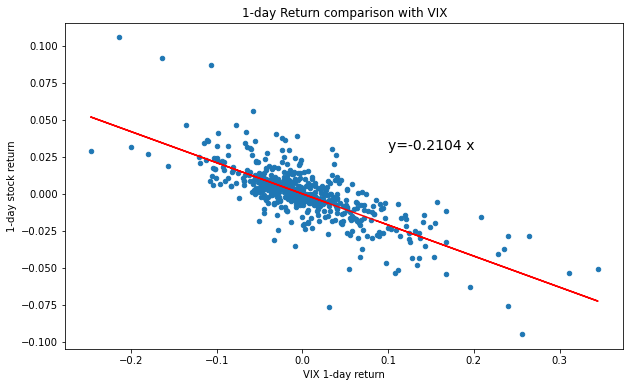

In [19]:
### Scatter plot for 1-day stock return with SPTR
fit_vix = np.polyfit(vix['VIX'], vix['Return'], deg=1)

vix.plot(kind='scatter', x ='VIX', y='Return', figsize=(10,6))
plt.xlabel('VIX 1-day return')
plt.ylabel('1-day stock return')

plt.plot(vix['VIX'], fit_vix[0]*vix['VIX'] + fit_sptr[1], color='red')
plt.annotate('y={0:.4f} x'.format(fit_vix[0]), xy=(0.1, 0.03), fontsize=14)
plt.title('1-day Return comparison with VIX')
plt.savefig('1dayVix.jpeg')
plt.show()

In [20]:
### Regression to check if VIX is a new factor or not
fac_reg = smf.ols('Return ~ mktrf + VIX', data=benchmark).fit()
fac_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     1426.
Date:                Fri, 16 Oct 2020   Prob (F-statistic):          8.85e-208
Time:                        18:57:11   Log-Likelihood:                 1752.0
No. Observations:                 505   AIC:                            -3498.
Df Residuals:                     502   BIC:                            -3485.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002      0.000     -0.720      0.472      -0.001       0.000
mktrf          0.7950      0.026     30.944      0.000       0.745       0.846
VIX           -0.0088      0.008     -1.079      0.281      -0.025       0.007
==============================================================================
Omnibus:                       67.455   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              387.343
Skew:                          -0.389   Prob(JB):                     7.75e-85
Kurtosis:                       7.219   Cond. No.                         78.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Question 2

In [21]:
### Importing return of the contra01 strategy
hedge = pd.read_excel('WeightedTCReturn.xlsx')
hedge['Date'] = pd.to_datetime(hedge['Date'], format='%m/%d/%Y')
hedge = hedge.set_index('Date')
### Removing the data after 2004
hedge = hedge[:'1/1/2005']
hedge.tail()

,Long,Short,TotalReturn
Date,,,
2004-12-27,-0.013984,-0.000243,-0.014226
2004-12-28,0.025333,-0.012864,0.012469
2004-12-29,0.001706,-0.008492,-0.006786
2004-12-30,0.021827,-0.012614,0.009214
2004-12-31,0.017335,-0.009486,0.007849


In [22]:
### Function for finding statistics 
### Input Series of return
def statistics(data, label):
    ann_return = data.mean()*252*100
    ann_vol = data.std()*math.sqrt(252)*100
    print(label + ' annualized Return is {:0.2f}%'.format(ann_return))
    print(label + ' annualized Volatility is {:0.2f}%'.format(ann_vol))
    print(label + ' sharpe Ratio is {:0.2f}'.format(ann_return/ann_vol))
    return

In [23]:
### Finding the basic statistics of the hedgefund return
statistics(hedge['TotalReturn'],'Total')

Total annualized Return is 110.75%
Total annualized Volatility is 24.45%
Total sharpe Ratio is 4.53


### CAPM

In [24]:
### Regressing the return with SPTR
ff_data = hedge.merge(data, left_index = True, right_index=True, how='left')
ff_data.head()

,Long,Short,TotalReturn,Beta,Return,SPX,SPTR,VIX,mktrf,smb,hml,rf,umd
Date,,,,,,,,,,,,,
2001-01-02,0.105302,0.016923,0.122225,0.733649,-0.029762,-0.028032,-0.028032,0.116946,-0.033912,-0.0039,0.0209,0.00026,-0.0123
2001-01-03,0.100026,-0.051626,0.048400,0.792108,0.055215,0.050099,0.050230,-0.113038,0.054113,0.0097,-0.0491,0.00026,-0.0727
2001-01-04,-0.014663,-0.048048,-0.062711,0.793228,-0.005814,-0.010552,-0.010528,0.013910,-0.012027,0.0082,-0.0014,0.00026,-0.0415
2001-01-05,0.003538,0.020182,0.023720,0.820053,-0.040936,-0.026242,-0.026236,0.063033,-0.028681,0.0027,0.0242,0.00026,0.0066
2001-01-08,-0.016666,0.035251,0.018585,0.820903,-0.003049,-0.001918,-0.001710,0.040809,-0.003693,-0.0054,0.0128,0.00026,0.0017


In [25]:
ff_data.tail()

,Long,Short,TotalReturn,Beta,Return,SPX,SPTR,VIX,mktrf,smb,hml,rf,umd
Date,,,,,,,,,,,,,
2004-12-27,-0.013984,-0.000243,-0.014226,0.614172,-0.001526,-0.004305,-0.004305,0.081033,-0.003992,-0.0020,-0.0003,0.00007,-0.0059
2004-12-28,0.025333,-0.012864,0.012469,0.599147,-0.000764,0.007154,0.007167,-0.011532,0.008032,0.0074,-0.0013,0.00007,0.0041
2004-12-29,0.001706,-0.008492,-0.006786,0.609069,0.003823,-0.000074,0.000072,-0.031667,0.000600,-0.0007,0.0003,0.00007,-0.0010
2004-12-30,0.021827,-0.012614,0.009214,0.609714,-0.002285,0.000082,0.000148,0.080895,0.000600,-0.0005,-0.0012,0.00007,-0.0045
2004-12-31,0.017335,-0.009486,0.007849,0.572151,0.001527,-0.001343,-0.001348,0.058121,-0.001099,0.0000,0.0020,0.00007,0.0004


In [26]:
### Running the CAPM regression 
capm_reg = smf.ols('TotalReturn ~ mktrf', data= ff_data).fit()
capm_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalReturn   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.067
Date:                Fri, 16 Oct 2020   Prob (F-statistic):             0.0139
Time:                        18:57:12   Log-Likelihood:                 2768.8
No. Observations:                1004   AIC:                            -5534.
Df Residuals:                    1002   BIC:                            -5524.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0044      0.000      9.037      0.000       0.003       0.005
mktrf          0.0989      0.040      2.463      0.014       0.020       0.178
==============================================================================
Omnibus:                      175.853   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              963.403
Skew:                           0.681   Prob(JB):                    6.31e-210
Kurtosis:                       7.602   Cond. No.                         82.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
### Running the Fama French Regression
ff_reg = smf.ols('TotalReturn ~ mktrf + smb + hml + umd', data=ff_data).fit()
ff_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalReturn   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.288
Date:                Fri, 16 Oct 2020   Prob (F-statistic):             0.0109
Time:                        18:57:12   Log-Likelihood:                 2772.3
No. Observations:                1004   AIC:                            -5535.
Df Residuals:                     999   BIC:                            -5510.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0044      0.000      9.116      0.000       0.003       0.005
mktrf          0.0528      0.051      1.034      0.301      -0.047       0.153
smb           -0.1506      0.087     -1.721      0.086      -0.322       0.021
hml            0.0512      0.113      0.452      0.651      -0.171       0.274
umd           -0.1129      0.066     -1.708      0.088      -0.243       0.017
==============================================================================
Omnibus:                      152.925   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              778.139
Skew:                           0.593   Prob(JB):                    1.07e-169
Kurtosis:                       7.147   Cond. No.                         256.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

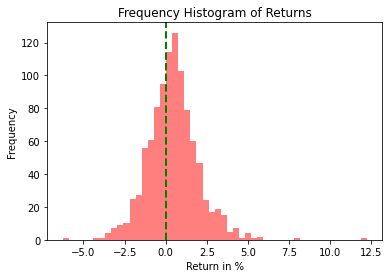

In [28]:
### Plotting the return in order
return_order = list(ff_data['TotalReturn']).sort()

kwargs = dict(alpha=0.5, bins=50)
plt.hist((ff_data['TotalReturn']*100).sort_values(ascending=True), **kwargs, color='r', label='Portfolio')
#plt.hist(Market_return*100, **kwargs, color='g', label='Market')
plt.gca().set(title='Frequency Histogram of Returns', ylabel='Frequency', xlabel = 'Return in %')
plt.axvline(0, linestyle='dashed', linewidth=2, color='g')
plt.savefig('Return_hist.jpeg')
plt.show()

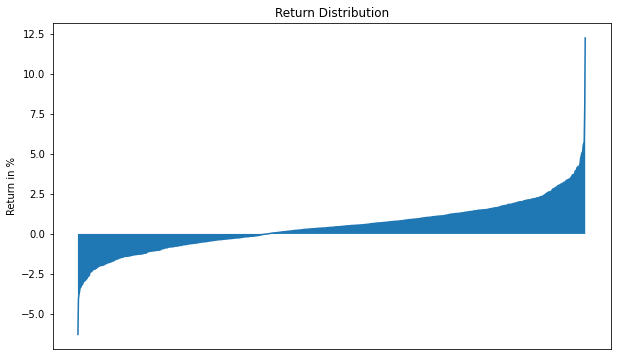

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
y1 = list((ff_data['TotalReturn']*100).sort_values(ascending=True))
x = list(range(len(y1)))
ax.plot(x, y1)
ax.fill_between(x, y1)
plt.title('Return Distribution')
plt.ylabel('Return in %')
ax.get_xaxis().set_visible(False)
plt.savefig('Returndist.jpeg')
plt.show()

In [30]:
### Finding fraction of losers and winners
y1 = np.array(y1)
winner = len(y1[y1>=0])
loser = len(y1[y1 <0])

print(winner/len(y1), loser/len(y1))

0.6274900398406374 0.37250996015936255


In [31]:
### Finding the quantile for loser and quantile for loser
print(pd.Series(y1[y1 >=0]).quantile(0.5))

print(pd.Series(y1[y1 < 0]).quantile(0.5))

1.0186588044589246
-0.8015545706994702


### Question 3

In [32]:
### Importing return of the contra01 strategy
hedge = pd.read_excel('WeightedTCReturn.xlsx')
hedge['Date'] = pd.to_datetime(hedge['Date'], format='%m/%d/%Y')
hedge = hedge.set_index('Date')
### Removing the data after 2004
hedge = hedge['1/1/2005':]
hedge.tail()

,Long,Short,TotalReturn
Date,,,
2009-12-24,0.001095,-0.008810,-0.007715
2009-12-28,-0.001951,-0.000890,-0.002842
2009-12-29,0.000924,-0.007746,-0.006822
2009-12-30,0.000217,-0.017385,-0.017168
2009-12-31,0.016242,0.006239,0.022481


In [33]:
### Finding the basic statistics of the hedgefund return
statistics(hedge['TotalReturn'],'Total')
statistics(hedge['Long'],'Long')
statistics(hedge['Short'],'Short')

Total annualized Return is 39.07%
Total annualized Volatility is 28.57%
Total sharpe Ratio is 1.37
Long annualized Return is -18.45%
Long annualized Volatility is 32.57%
Long sharpe Ratio is -0.57
Short annualized Return is 57.52%
Short annualized Volatility is 28.68%
Short sharpe Ratio is 2.01


In [34]:
### Regressing the return with SPTR
ff_data = hedge.merge(data, left_index = True, right_index=True, how='left')
ff_data.head()

,Long,Short,TotalReturn,Beta,Return,SPX,SPTR,VIX,mktrf,smb,hml,rf,umd
Date,,,,,,,,,,,,,
2005-01-03,-0.004495,0.017879,0.013384,0.585119,-0.009146,-0.008119,-0.008109,0.059443,-0.010049,-0.0056,-0.0019,0.00008,-0.0067
2005-01-04,-0.011104,0.024510,0.013406,0.610066,-0.012308,-0.011671,-0.011571,-0.007102,-0.012817,-0.0057,0.0049,0.00008,0.0025
2005-01-05,-0.014746,0.008916,-0.005830,0.613396,-0.003115,-0.003628,-0.003534,0.007868,-0.006181,-0.0106,0.0001,0.00008,0.0001
2005-01-06,0.002718,0.000669,0.003387,0.632305,0.006250,0.003506,0.003731,-0.036196,0.003406,-0.0014,0.0017,0.00008,0.0005
2005-01-07,-0.010462,-0.003421,-0.013883,0.632809,0.001553,-0.001431,-0.001418,-0.006627,-0.002297,-0.0075,-0.0003,0.00008,-0.0017


In [35]:
### Running the CAPM regression 
capm_reg = smf.ols('TotalReturn ~ mktrf', data= ff_data).fit()
capm_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalReturn   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3539
Date:                Fri, 16 Oct 2020   Prob (F-statistic):              0.552
Time:                        18:57:12   Log-Likelihood:                 3272.2
No. Observations:                1259   AIC:                            -6540.
Df Residuals:                    1257   BIC:                            -6530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0015      0.001      3.048      0.002       0.001       0.003
mktrf          0.0199      0.033      0.595      0.552      -0.046       0.085
==============================================================================
Omnibus:                      368.934   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3760.091
Skew:                           1.053   Prob(JB):                         0.00
Kurtosis:                      11.200   Cond. No.                         65.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
### Running the Fama French Regression
ff_reg = smf.ols('TotalReturn ~ mktrf + smb + hml', data=ff_data).fit()
ff_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalReturn   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6826
Date:                Fri, 16 Oct 2020   Prob (F-statistic):              0.563
Time:                        18:57:12   Log-Likelihood:                 3273.0
No. Observations:                1259   AIC:                            -6538.
Df Residuals:                    1255   BIC:                            -6518.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0015      0.001      3.030      0.002       0.001       0.003
mktrf          0.0008      0.038      0.020      0.984      -0.074       0.075
smb            0.0704      0.083      0.849      0.396      -0.092       0.233
hml            0.0865      0.083      1.042      0.298      -0.076       0.249
==============================================================================
Omnibus:                      362.913   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3639.600
Skew:                           1.036   Prob(JB):                         0.00
Kurtosis:                      11.068   Cond. No.                         172.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

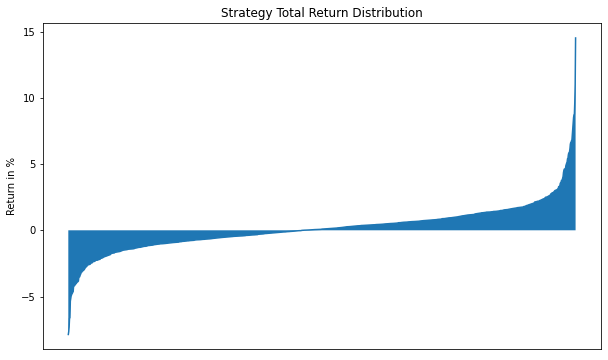

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
y1 = list((ff_data['TotalReturn']*100).sort_values(ascending=True))
x = list(range(len(y1)))
ax.plot(x, y1)
ax.fill_between(x, y1)
plt.title('Strategy Total Return Distribution')
plt.ylabel('Return in %')
ax.get_xaxis().set_visible(False)
plt.savefig('Returndist_2.jpeg')
plt.show()

In [38]:
### Finding fraction of losers and winners
y1 = np.array(y1)
winner = len(y1[y1>=0])
loser = len(y1[y1 <0])

print(winner/len(y1), loser/len(y1))
### Finding the quantile for loser and quantile for loser
print(pd.Series(y1[y1 >=0]).quantile(0.5))

print(pd.Series(y1[y1 < 0]).quantile(0.5))

0.5361397934868943 0.46386020651310567
0.8375980691244981
-0.8158489557981297


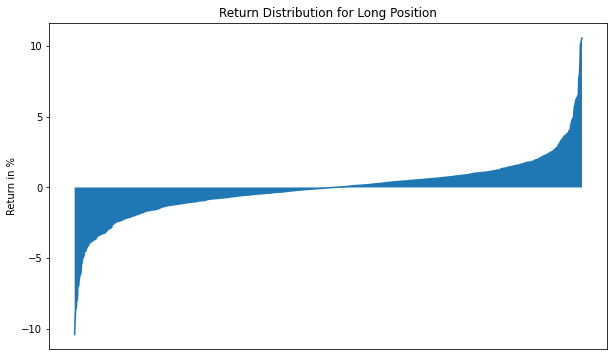

In [39]:
### For Long Position
fig, ax = plt.subplots(figsize=(10,6))
y1 = list((ff_data['Long']*100).sort_values(ascending=True))
x = list(range(len(y1)))
ax.plot(x, y1)
ax.fill_between(x, y1)
plt.title('Return Distribution for Long Position')
plt.ylabel('Return in %')
ax.get_xaxis().set_visible(False)
plt.savefig('Returndist_Long.jpeg')
plt.show()

In [40]:
### Finding fraction of losers and winners
y1 = np.array(y1)
winner = len(y1[y1>=0])
loser = len(y1[y1 <0])

print(winner/len(y1), loser/len(y1))
### Finding the quantile for loser and quantile for loser
print(pd.Series(y1[y1 >=0]).quantile(0.5))

print(pd.Series(y1[y1 < 0]).quantile(0.5))

0.4892772041302621 0.5107227958697379
0.8196000823143426
-0.9227437409671718


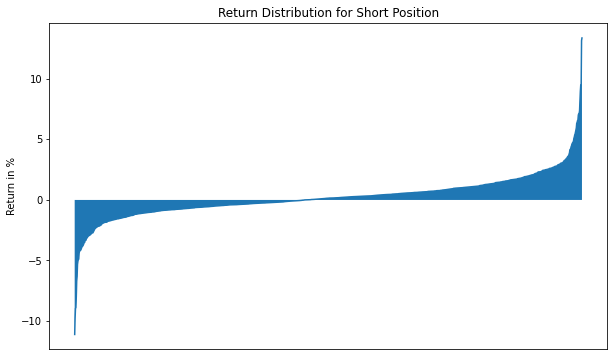

In [41]:
### For Long Position
fig, ax = plt.subplots(figsize=(10,6))
y1 = list((ff_data['Short']*100).sort_values(ascending=True))
x = list(range(len(y1)))
ax.plot(x, y1)
ax.fill_between(x, y1)
plt.title('Return Distribution for Short Position')
plt.ylabel('Return in %')
ax.get_xaxis().set_visible(False)
plt.savefig('Returndist_short.jpeg')
plt.show()

In [42]:
### Finding fraction of losers and winners
y1 = np.array(y1)
winner = len(y1[y1>=0])
loser = len(y1[y1 <0])

print(winner/len(y1), loser/len(y1))
### Finding the quantile for loser and quantile for loser
print(pd.Series(y1[y1 >=0]).quantile(0.5))

print(pd.Series(y1[y1 < 0]).quantile(0.5))

0.5472597299444003 0.4527402700555997
0.8191479798295767
-0.6840127978545804


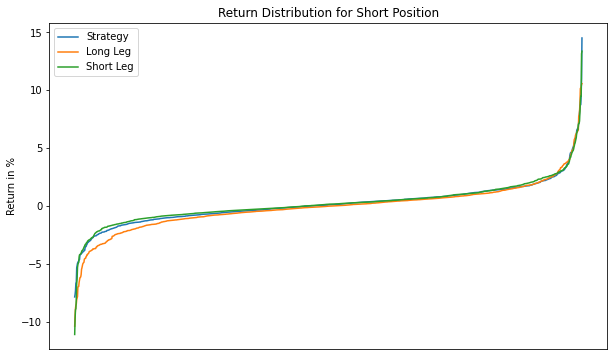

In [43]:
### For Long Position
fig, ax = plt.subplots(figsize=(10,6))
y1 = list((ff_data['TotalReturn']*100).sort_values(ascending=True))
y2 = list((ff_data['Long']*100).sort_values(ascending=True))
y3 = list((ff_data['Short']*100).sort_values(ascending=True))
x = list(range(len(y1)))
ax.plot(x, y1, label='Strategy')
ax.plot(x, y2, label ='Long Leg')
ax.plot(x, y3, label ='Short Leg')
#ax.fill_between(x, y1)
plt.title('Return Distribution for Short Position')
plt.ylabel('Return in %')
ax.get_xaxis().set_visible(False)
plt.legend()
#plt.savefig('Returndist_short.jpeg')
plt.show()

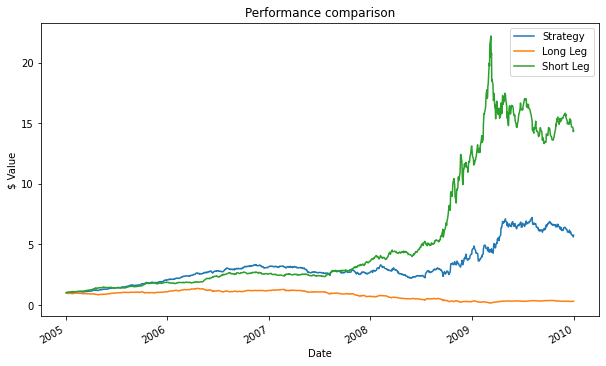

In [44]:
### Forming index with overall strategy, long leg and short leg

(ff_data['TotalReturn'] + 1).cumprod().plot(label='Strategy', figsize=(10,6))
(ff_data['Long'] + 1).cumprod().plot(label='Long Leg')
(ff_data['Short'] + 1).cumprod().plot(label='Short Leg')
plt.title('Performance comparison')
plt.ylabel('$ Value')
plt.legend()
plt.savefig('PerformanceComp.jpeg')
plt.show()

### Question 4

In [45]:
weight = pd.read_excel('Weight.xlsx')
weight.head()
### Filling all the NA with 0s
weight = weight.fillna(0)
weight.head()
weight['Date'] = pd.to_datetime(weight['Date'], format='%m/%d/%Y')
weight.set_index('Date', inplace=True)

### Subsetting data from 2005 to 2009
weight = weight['1/1/2005':]
weight.tail()

,NA,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Telecommunication Services,Utilities
Date,,,,,,,,,,,
2009-12-24,0.031250,0.015625,-0.03125,-0.046875,0.093750,0.015625,-0.046875,0.125000,-0.140625,0.000000,-0.015625
2009-12-28,-0.031250,-0.031250,0.00000,0.078125,-0.109375,0.000000,-0.031250,0.109375,-0.015625,0.015625,0.015625
2009-12-29,0.015625,-0.015625,-0.03125,0.031250,0.046875,-0.031250,0.093750,-0.031250,-0.093750,0.031250,-0.015625
2009-12-30,0.125000,-0.031250,0.00000,-0.015625,-0.046875,-0.062500,-0.015625,0.078125,-0.015625,-0.031250,0.000000
2009-12-31,0.140625,-0.093750,0.03125,-0.093750,0.015625,0.015625,-0.093750,0.109375,-0.015625,-0.015625,0.000000


In [46]:
### Finding the highest net exposure
weight.max(axis=0)*100

NA                            30.985915
Energy                        30.985915
Materials                     16.901408
Industrials                   16.279070
Consumer Discretionary        19.402985
Consumer Staples               9.230769
Health Care                   24.137931
Financials                    33.333333
Information Technology        24.096386
Telecommunication Services     4.210526
Utilities                      3.529412
dtype: float64

In [47]:
weight.min(axis=0)*100

NA                           -22.222222
Energy                       -23.255814
Materials                    -12.676056
Industrials                  -18.987342
Consumer Discretionary       -24.000000
Consumer Staples              -8.000000
Health Care                  -22.222222
Financials                   -48.717949
Information Technology       -23.595506
Telecommunication Services    -5.128205
Utilities                     -4.761905
dtype: float64

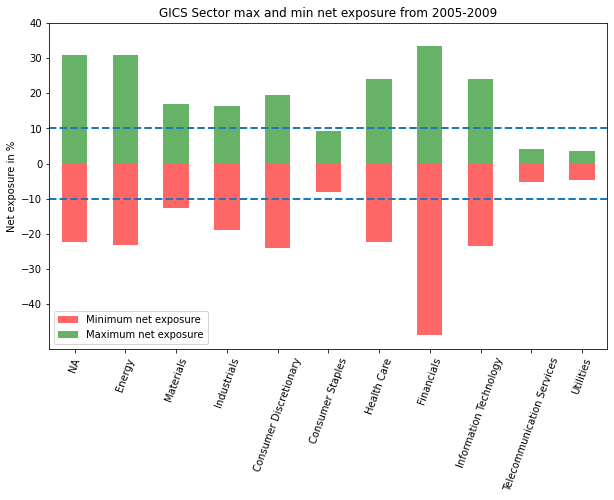

In [48]:
kwargs = dict(alpha=0.6)
(weight.min(axis=0)*100).plot.bar(color='red', figsize=(10,6),**kwargs, label='Minimum net exposure')
(weight.max(axis=0)*100).plot.bar(color='green',**kwargs, label='Maximum net exposure')
plt.ylabel('Net exposure in %')
plt.title('GICS Sector max and min net exposure from 2005-2009')
plt.legend(loc='lower left')
plt.xticks(rotation=70)
plt.yticks([-40,-30,-20,-10,0,10,20,30,40])
plt.axhline(-10, linestyle = 'dashed', linewidth=2)
plt.axhline(10, linestyle='dashed', linewidth=2)
plt.savefig('MaxMinExposure.jpeg',bbox_inches='tight')
plt.show()

In [49]:
weight.loc['9/15/2008'].sort_values(ascending=False)

NA                            0.112676
Health Care                   0.070423
Information Technology        0.056338
Utilities                     0.000000
Telecommunication Services    0.000000
Materials                     0.000000
Consumer Staples             -0.014085
Financials                   -0.028169
Industrials                  -0.028169
Energy                       -0.070423
Consumer Discretionary       -0.084507
Name: 2008-09-15 00:00:00, dtype: float64

In [50]:
print(np.sum(weight.loc['9/15/2008'][weight.loc['9/15/2008'] >0]))
print(np.sum(weight.loc['9/15/2008'][weight.loc['9/15/2008'] <0]))
print(np.sum(weight.loc['9/15/2008']))

0.23943661971399993
-0.22535211267200003
0.014084507041999914


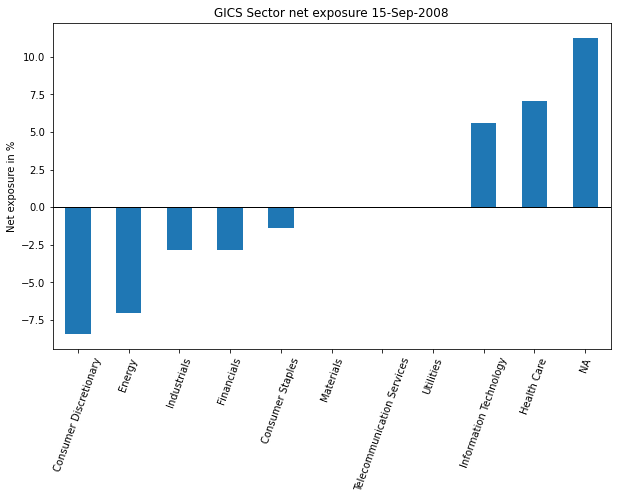

In [51]:
(weight.loc['9/15/2008']*100).sort_values(ascending=True).plot.bar(figsize=(10,6))
plt.ylabel('Net exposure in %')
plt.title('GICS Sector net exposure 15-Sep-2008')
#plt.legend(loc='lower right')
plt.xticks(rotation=70)
plt.axhline(0, linewidth=1, color='black')
plt.savefig('SepExposure.jpeg',bbox_inches='tight')
plt.show()

In [52]:
weight.loc['2/27/2007'].sort_values(ascending=False)

NA                            0.060976
Industrials                   0.048780
Consumer Staples              0.024390
Financials                    0.012195
Consumer Discretionary        0.012195
Telecommunication Services    0.012195
Utilities                     0.000000
Health Care                   0.000000
Materials                     0.000000
Energy                       -0.012195
Information Technology       -0.146341
Name: 2007-02-27 00:00:00, dtype: float64

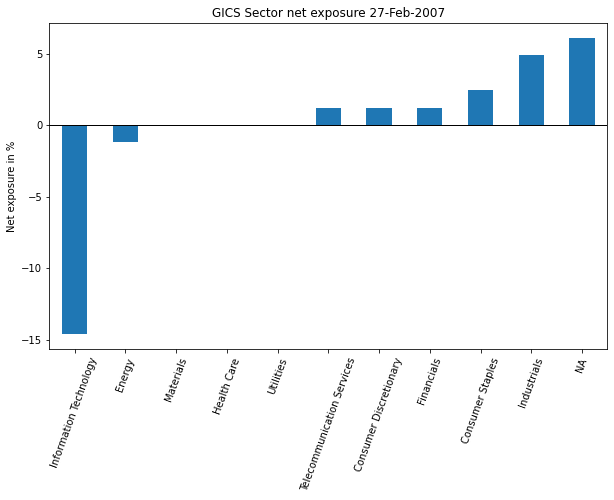

In [53]:
(weight.loc['2/27/2007']*100).sort_values(ascending=True).plot.bar(figsize=(10,6))
plt.ylabel('Net exposure in %')
plt.title('GICS Sector net exposure 27-Feb-2007')
#plt.legend(loc='lower right')
plt.xticks(rotation=70)
plt.axhline(0, linewidth=1, color='black')
plt.savefig('FebExposure.jpeg',bbox_inches='tight')
plt.show()

In [54]:
print(np.sum(weight.loc['2/27/2007'][weight.loc['2/27/2007'] >0]))
print(np.sum(weight.loc['2/27/2007'][weight.loc['2/27/2007'] <0]))
print(np.sum(weight.loc['2/27/2007']))

0.17073170731399992
-0.158536585363
0.01219512195099989


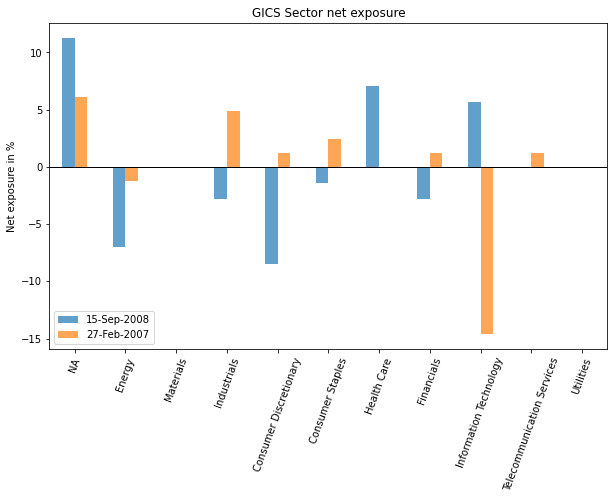

In [55]:
df = pd.DataFrame({'15-Sep-2008':weight.loc['9/15/2008']*100, '27-Feb-2007': weight.loc['2/27/2007']*100})
kwargs = dict(alpha=0.7)
df.plot.bar(figsize=(10,6),**kwargs)
plt.ylabel('Net exposure in %')
plt.title('GICS Sector net exposure')
plt.legend(loc='lower left')
plt.xticks(rotation=70)
plt.axhline(0, linewidth=1, color='black')
plt.savefig('CompExposure.jpeg',bbox_inches='tight')
plt.show()


In [56]:
### Finding the portfolio performance using financials
fin_ret = pd.read_excel('FinancialPort.xlsx')
fin_ret['Date'] = pd.to_datetime(fin_ret['Date'],format='%m/%d/%Y')
fin_ret.set_index('Date', inplace=True)
fin_ret = fin_ret.merge(data, left_index=True, right_index=True, how='left')
fin_ret.head()

,Long,Short,TotalReturn,Beta,Return,SPX,SPTR,VIX,mktrf,smb,hml,rf,umd
Date,,,,,,,,,,,,,
2005-01-03,0.000453,-0.000921,-0.000468,0.585119,-0.009146,-0.008119,-0.008109,0.059443,-0.010049,-0.0056,-0.0019,0.00008,-0.0067
2005-01-04,0.000109,0.001314,0.001423,0.610066,-0.012308,-0.011671,-0.011571,-0.007102,-0.012817,-0.0057,0.0049,0.00008,0.0025
2005-01-05,-0.000180,-0.000711,-0.000891,0.613396,-0.003115,-0.003628,-0.003534,0.007868,-0.006181,-0.0106,0.0001,0.00008,0.0001
2005-01-06,-0.000173,0.000003,-0.000170,0.632305,0.006250,0.003506,0.003731,-0.036196,0.003406,-0.0014,0.0017,0.00008,0.0005
2005-01-07,0.000545,0.000859,0.001403,0.632809,0.001553,-0.001431,-0.001418,-0.006627,-0.002297,-0.0075,-0.0003,0.00008,-0.0017


In [57]:
fin_ret.tail()

,Long,Short,TotalReturn,Beta,Return,SPX,SPTR,VIX,mktrf,smb,hml,rf,umd
Date,,,,,,,,,,,,,
2009-12-24,0.007593,0.000211,0.007804,0.955339,0.004200,0.005256,0.005254,-0.012177,0.005214,-0.0008,0.0016,0.0,0.0025
2009-12-28,-0.007774,-0.000058,-0.007832,0.955054,0.000738,0.001154,0.001286,0.023626,0.001001,-0.0015,-0.0030,0.0,-0.0018
2009-12-29,0.001205,-0.004967,-0.003762,0.954065,-0.000983,-0.001401,-0.001227,0.004014,-0.000900,0.0008,-0.0008,0.0,-0.0037
2009-12-30,0.006554,-0.005723,0.000831,0.954356,-0.001968,0.000195,0.000287,-0.002499,-0.000700,-0.0004,-0.0018,0.0,-0.0010
2009-12-31,0.008854,-0.002180,0.006674,0.950090,-0.003945,-0.010050,-0.010043,0.086172,-0.008761,-0.0013,0.0015,0.0,0.0005


In [58]:
statistics(fin_ret['TotalReturn'],'Financial')

Financial annualized Return is 6.59%
Financial annualized Volatility is 9.77%
Financial sharpe Ratio is 0.67


In [59]:
### Checking the market neutrality of return
fin_reg = smf.ols('TotalReturn ~ mktrf', data=fin_ret).fit()
fin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalReturn   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01771
Date:                Fri, 16 Oct 2020   Prob (F-statistic):              0.894
Time:                        18:57:14   Log-Likelihood:                 4623.1
No. Observations:                1259   AIC:                            -9242.
Df Residuals:                    1257   BIC:                            -9232.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.000      1.508      0.132   -7.88e-05       0.001
mktrf         -0.0015      0.011     -0.133      0.894      -0.024       0.021
==============================================================================
Omnibus:                      476.886   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36845.951
Skew:                          -0.843   Prob(JB):                         0.00
Kurtosis:                      29.449   Cond. No.                         65.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
### Finding the net and gross exposure
fin_ret = pd.read_excel('FinancialWeight.xlsx')
fin_ret['Date'] = pd.to_datetime(fin_ret['Date'],format='%m/%d/%Y')
fin_ret.set_index('Date', inplace=True)
fin_ret.head()

,Long,Short,Total Weigh
Date,,,
2005-01-03,0.010417,-0.031250,-0.020833
2005-01-04,0.062500,-0.083333,-0.020833
2005-01-05,0.020833,-0.041667,-0.020833
2005-01-06,0.020833,-0.052083,-0.031250
2005-01-07,0.031250,-0.104167,-0.072917


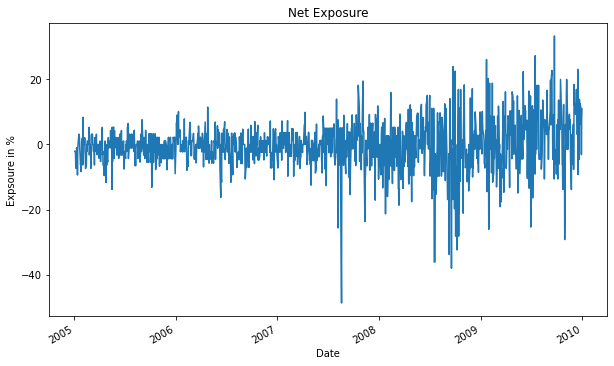

In [61]:
### Plotting the net exposure
(fin_ret['Total Weigh']*100).plot( figsize=(10,6))
plt.title('Net Exposure')
plt.ylabel('Expsoure in %')
plt.savefig('NetExposure.jpeg')
plt.show()

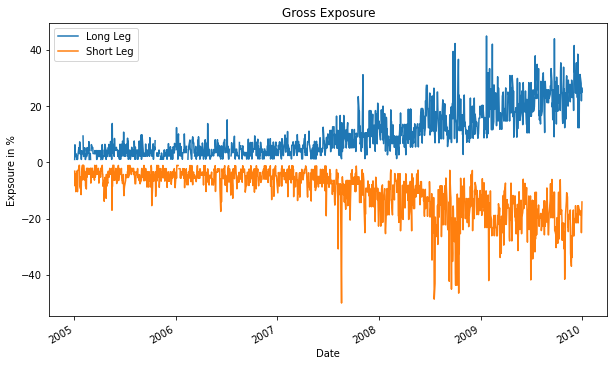

In [62]:
### Plotting the net exposure
(fin_ret['Long']*100).plot(label='Long Leg', figsize=(10,6))
(fin_ret['Short']*100).plot(label='Short Leg', figsize=(10,6))
plt.title('Gross Exposure')
plt.ylabel('Expsoure in %')
plt.legend()
plt.savefig('GrossExposure.jpeg')
plt.show()